## Demo Custom Word Embedding Creation using Gensim

### Imports

In [1]:
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import (preprocess_string, strip_tags, 
    strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords)
import pandas as pd
import numpy as np
import scipy
from sklearn.manifold import TSNE
import matplotlib.pylab as plt
import matplotlib.cm as cm

%matplotlib inline

C:\Users\Diamond\Anaconda2\envs\tensorFlow-py35\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Constants and Variables

In [2]:
WORD_EMBEDDING_CACHE_PATH = r"Model\model.bin"
EMPLOYEE_DOCS_STORE_PATH = r'Data\Employee_doc_store.csv'
EMPLOYER_DOCS_STORE_PATH = r'Data\Employer_doc_store.csv'
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, 
                  strip_numeric, remove_stopwords]
CACHED_DOC2VEC_MODEL = None
SEED = 100

### Get Employer and Employee Docs

In [3]:
df_employee_docs = pd.read_csv(EMPLOYEE_DOCS_STORE_PATH, encoding = "ISO-8859-1")
df_employer_docs = pd.read_csv(EMPLOYER_DOCS_STORE_PATH, encoding = "ISO-8859-1")

### Some document stats

In [4]:
n_employee_docs = df_employee_docs.shape[0]
print("Number of Employee documents is: {}".format(n_employee_docs))

Number of Employee documents is: 20


### Remove NaN rows from Docs

In [5]:
df_employee_docs_new = df_employee_docs.dropna()
df_employer_docs_new = df_employer_docs.dropna()

### Sample the Docs

In [6]:
df_employee_docs_new.head()

,Unnamed: 0,username,key_skills_doc,CV_details_doc
0,0,vijaynair,"PHP, HTML, CSS, JavaScript, jQuery, Oracle Dat...","Developing web sites, Testing applications Pro..."
1,1,ram.rag1,"Change Management, Change Management, Start-up...",It is our mission to empower leaders to put th...
3,3,adeidowu,Msc Finance,Computing and Finance
4,4,martin31robert,"Training Design, Training Delivery, People Man...",Human Resources
5,5,joseph.martin,"IT Infrastructure, Data Mining, Business Analy...",Computer Science


In [7]:
df_employer_docs_new

,Unnamed: 0,employer_user_name,vacancy_id,key_skills_doc,CV_details_doc
0,0,vijayadmin,31,"CA, ICWA, MBA Accounting degree",We are searching to fill 10 positions in acco...


### Convert Docs into list of list of strings

In [8]:
employee_docs = df_employee_docs_new.CV_details_doc.tolist()
employer_docs = df_employer_docs_new.CV_details_doc.tolist()

### Apply some NLP preprocessing to clean the docs

In [9]:
def preProcessDocs(doc, filters):
    return list(set(preprocess_string(doc, filters)))

employee_docs_clean = [preProcessDocs(doc, CUSTOM_FILTERS) for doc in employee_docs]
employer_docs_clean = [preProcessDocs(doc, CUSTOM_FILTERS) for doc in employer_docs]

### Sample cleaned Docs

In [10]:
employee_docs_clean[0]

['testing',
 'commerce',
 'web',
 'programmer',
 'references',
 'costing',
 'tester',
 'application',
 'developing',
 'sites',
 'applications']

In [11]:
employer_docs_clean[0]

['experience',
 'years',
 'organisation',
 'manager',
 'senior',
 'levels',
 'accounts',
 'managers',
 'ranging',
 'section',
 'varying',
 'department',
 'reputed',
 'assistant',
 'positions',
 'searching']

### Concatenate the Employee and Employer Docs
- This will be used to build a combined word embedding

In [12]:
train_docs = employee_docs_clean + employer_docs_clean

### Word Embedding Process

In [13]:
# train model
model = Word2Vec(train_docs, min_count=1)
# summarize the loaded model
print("Word Embedding Model is:\n{}\n\n".format(model))
# summarize vocabulary
words = list(model.wv.vocab)
print("Word Embedding vocabulary is:\n{}\n\n".format(words))

# access vector for one word
print("Word Embedding Vector for the word 'manager' is\n{}\n\n".format(model['manager']))
# save model
model.save(WORD_EMBEDDING_CACHE_PATH)
# load model
new_model = Word2Vec.load(WORD_EMBEDDING_CACHE_PATH)
print(new_model)

Word Embedding Model is:
Word2Vec(vocab=440, size=100, alpha=0.025)


Word Embedding vocabulary is:
['aware', 'certified', 'mentored', 'understood', 'motivate', 'way', 'profits', 'leaders', 'rare', 'impressive', 'started', 'act', 'phd', 'scholarship', 'forward', 'states', 'authentic', 'feedback', 'driving', 'empower', 'foster', 'want', 'combine', 'applause', 'pursued', 'helping', 'senior', 'problems', 'raghvan', 'multiple', 'discovery', 'application', 'issues', 'enables', 'simulation', 'department', 'advice', 'enormously', 'focus', 'mission', 'bring', 'like', 'debate', 'saw', 'solutions', 'doctoral', 'team', 'achievements', 'completed', 'strategic', 'frtb', 'knew', 'academically', 'impact', 'organisation', 'heart', 'impressed', 'web', 'strategy', 'deliberate', 'world', 'led', 'panache', 'basel', 'felt', 'listen', 'organisational', 'derivatives', 'pre', 'priveleged', 'order', 'results', 'credit', 'equities', 'talengene', 'understanding', 'technology', 'wide', 'assert', 'applications', '

C:\Users\Diamond\Anaconda2\envs\tensorFlow-py35\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


### Define the Cosine Similarity Measure b/w 2 docs

In [14]:
test_docs = employee_docs_clean[:5]
ref_doc = employer_docs_clean[0]

In [15]:
def computeCosineSimilaritymeasure(s1, s2):    
    print("s1:\n{}\n".format(s1))
    print("s2:\n{}\n".format(s2))
    vector_1 = np.mean([new_model[word] for word in s1],axis=0)
    vector_2 = np.mean([new_model[word] for word in s2],axis=0)
    #print("vector_1.shape:{0}, vector_2.shape{1}".format(vector_1.shape, vector_2.shape))
    cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
    percent_similarity_measure = round((1-cosine)*100.0,2)
    print("Word Embedding similarity b/w two sentences is: {}\n\n".format(percent_similarity_measure))
    return percent_similarity_measure

def computeCosineSimilarityForDocs(test_docs, ref_doc):
    similarity_measures = []
    for test_doc in test_docs:
        similarity_measure = computeCosineSimilaritymeasure(ref_doc, test_doc)
        similarity_measures.append(similarity_measure)
    return similarity_measures

In [16]:
#sim_measures = computeCosineSimilarityForDocs(test_docs, ref_doc)
#test_docs = [ref_doc]
sim_measures = computeCosineSimilarityForDocs(test_docs, ref_doc)


s1:
['experience', 'years', 'organisation', 'manager', 'senior', 'levels', 'accounts', 'managers', 'ranging', 'section', 'varying', 'department', 'reputed', 'assistant', 'positions', 'searching']

s2:
['testing', 'commerce', 'web', 'programmer', 'references', 'costing', 'tester', 'application', 'developing', 'sites', 'applications']

Word Embedding similarity b/w two sentences is: -7.27


s1:
['experience', 'years', 'organisation', 'manager', 'senior', 'levels', 'accounts', 'managers', 'ranging', 'section', 'varying', 'department', 'reputed', 'assistant', 'positions', 'searching']

s2:
['deep', 'aware', 'started', 'sense', 'ground', 'need', 'mentored', 'peers', 'motivate', 'profits', 'leaders', 'technical', 'professional', 'rare', 'strategy', 'impressive', 'mba', 'act', 'assimilate', 'campus', 'appeal', 'scholarship', 'systems', 'number', 'states', 'behavior', 'authentic', 'primarily', 'driving', 'feedback', 'empower', 'foster', 'characteristic', 'want', 'met', 'applause', 'digital', '

C:\Users\Diamond\Anaconda2\envs\tensorFlow-py35\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
C:\Users\Diamond\Anaconda2\envs\tensorFlow-py35\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


### Visualize Similarity between the Documents
- Using T-distribution Stochastic Neigbourhood Embedding with PCA

### Build the label and 2D - spacial datasets

doc_1_vec.shape: (335, 100)
doc_2_vec.shape: (16, 100)
doc_all_vec.shape: (351, 100)


C:\Users\Diamond\Anaconda2\envs\tensorFlow-py35\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Diamond\Anaconda2\envs\tensorFlow-py35\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


doc_1_vec_2d.shape: (335, 2)
doc_2_vec_2d.shape: (16, 2)
doc_all_vec_2d.shape: (351, 2)


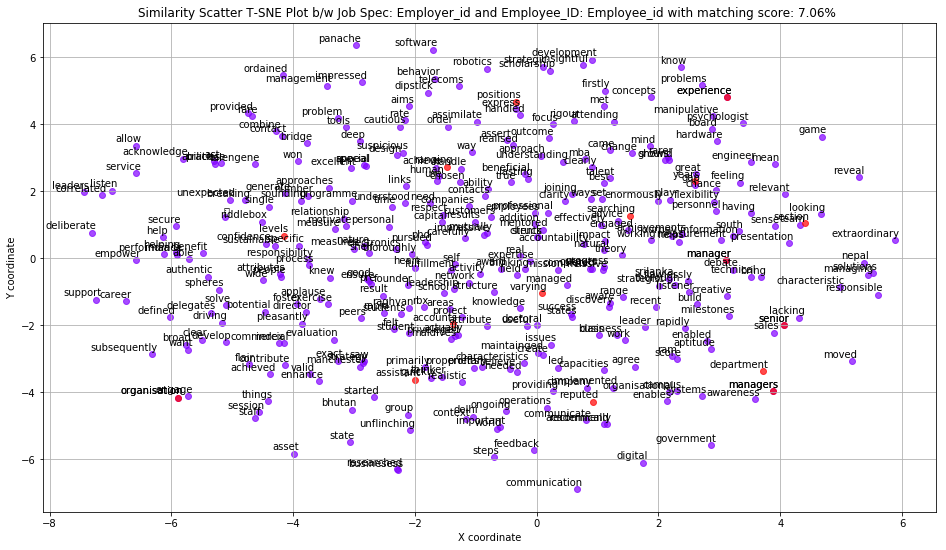

In [17]:
def computeLabelAnd2DSpacialDatasets(doc_1, doc_2, score, employer_id, employee_id):    
    doc_1_vec = np.array([new_model[word] for word in doc_1])
    doc_2_vec = np.array([new_model[word] for word in doc_2])
    doc_all_vec = np.vstack((doc_1_vec, doc_2_vec))
    n_doc_1_tokens = doc_1_vec.shape[0]
    n_doc_2_tokens = doc_2_vec.shape[0]
    n_doc_all_tokens = doc_all_vec.shape[0]
    doc_all_vec = np.vstack((doc_1_vec, doc_2_vec))
    print('doc_1_vec.shape: {}'.format(doc_1_vec.shape))
    print('doc_2_vec.shape: {}'.format(doc_2_vec.shape))
    print('doc_all_vec.shape: {}'.format(doc_all_vec.shape))
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)
    doc_all_vec_2d = tsne_model.fit_transform(doc_all_vec)
    doc_1_vec_2d = doc_all_vec_2d[:n_doc_1_tokens]
    doc_2_vec_2d = doc_all_vec_2d[n_doc_1_tokens:n_doc_all_tokens]
    print('doc_1_vec_2d.shape: {}'.format(doc_1_vec_2d.shape))
    print('doc_2_vec_2d.shape: {}'.format(doc_2_vec_2d.shape))
    print('doc_all_vec_2d.shape: {}'.format(doc_all_vec_2d.shape))
    
    plot_data = ([doc_1, doc_1_vec_2d], [doc_2, doc_2_vec_2d])
    n_docs = 2
    colors = cm.rainbow(np.linspace(0, 1, n_docs))
    plt.figure(figsize=(16, 9))
    for k, plot_data_i in enumerate(plot_data):
        labels = plot_data_i[0]
        coordinates = plot_data_i[1]
        plt.scatter(coordinates[:,0],coordinates[:,1],color=colors[k], alpha=0.7)
        for i in range(len(labels)):            
            plt.annotate(labels[i],
                         xy=(coordinates[i,0],coordinates[i,1]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    title = "Similarity Scatter T-SNE Plot b/w Job Spec: {0} and Employee_ID: {1} with matching score: {2:.2f}% ".format(
                                                                                        employer_id, employee_id, score)
    plt.title(title)
    plt.grid(True)
    plt.show()

score = sim_measures[1]
doc_1 = test_docs[1]
doc_2 = ref_doc
employer_id = "Employer_id"
employee_id = "Employee_id"
computeLabelAnd2DSpacialDatasets(doc_1, doc_2, score, employer_id, employee_id)

In [18]:
import numpy as np
a = np.array([10,20, 30, 40])
b = np.array([15,25,35,45])
c = np.vstack((a,b))

In [19]:
c_mean = np.mean(c, axis=0)
c_mean

array([12.5, 22.5, 32.5, 42.5])